In [1]:
%matplotlib inline
import inspect, os, sys, copy, pytz, re, glob
import simplejson as json
import pandas as pd
from dateutil import parser
import datetime
import matplotlib.pyplot as plt   # Matplotlib for plotting
import matplotlib.dates as md
import numpy as np
import seaborn as sns
from collections import Counter, defaultdict
import re, urllib

utc=pytz.UTC

ENV = "production"
os.environ['CS_ENV'] = 'production'
BASE_DIR = "/home/reddit/CivilServant"
sys.path.append(BASE_DIR)
subreddit_id = "2qh13"

with open(os.path.join(BASE_DIR, "config") + "/{env}.json".format(env=ENV), "r") as config:
  DBCONFIG = json.loads(config.read())

### LOAD SQLALCHEMY
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy import text, and_, or_
from app.models import Base, SubredditPage, FrontPage, Subreddit, Post, ModAction, Experiment
from utils.common import PageType

db_engine = create_engine("mysql://{user}:{password}@{host}/{database}".format(
    host = DBCONFIG['host'],
    user = DBCONFIG['user'],
    password = DBCONFIG['password'],
    database = DBCONFIG['database']))
DBSession = sessionmaker(bind=db_engine)
db_session = DBSession()

### LOAD PRAW
import reddit.connection
conn = reddit.connection.Connect(base_dir=BASE_DIR, env="jupyter")

### FILTER OUT DEPRECATION WARNINGS ASSOCIATED WITH DECORATORS
# https://github.com/ipython/ipython/issues/9242
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, message='.*use @default decorator instead.*')

### Goals of this notebook
The goal of this notebook is to conduct an analysis of the r/worldnews experiment

In [2]:
### CONNECT TO PRAW
r = conn.connect(controller="ModLog")

Version 3.5.0 of praw is outdated. Version 4.3.0 was released Thursday January 19, 2017.


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/v1/me.json
POST: https://api.reddit.com/api/v1/access_token/
substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/v1/me.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/v1/me.json


### Create a Dataset of Posts from Worldnews in the Observation Period

In [3]:
tabloid_domains = [ 'dailymail.co.uk', 'express.co.uk','mirror.co.uk', 'news.com.au', 
                    'nypost.com', 'thesun.co.uk','dailystar.co.uk','metro.co.uk']
msm_domains     = [ "bbc.com", "reuters.com", "nytimes.com", "washingtonpost.com", "cnn.com", 
                    "telegraph.co.uk", "latimes.com", "huffingtonpost.com", "theguardian.com", "forbes.com",
                    "examiner.com", "usatoday.com", "wsj.com", "cbsnews.com", "cbc.ca", "time.com",
                    "sfgate.com", "newsweek.com", "bostonglobe.com", "nydailynews.com", "msnbc.com",
                    "foxnews.com", "aljazeera.com", "nbcnews.com", "npr.org", "bloomberg.com", "abcnews.com", 
                    "aljazeera.com", "bigstory.ap.com", "cbc.ca", "time.com"]

omitted_matches = ["reddit", "img", "image", "giphy", "quickmeme"]

bots = ['autotldr', 'Mentioned_Videos', 'DailMail_Bot', 'youtubefactsbot', 'HelperBot_']

all_posts = {}
query_text = """
select * from experiment_things 
    JOIN posts ON experiment_things.id = posts.id 
    WHERE experiment_id=8 
    AND object_type=1 
    AND posts.created_at <= DATE_SUB( NOW() , INTERVAL 1 DAY )
    AND posts.created_at <= '2017-01-20 13:18:22'
    ORDER BY posts.created ASC;
"""

## ADDED THE SECOND CREATED_AT TO PRESERVE EXPERIMENT INTEGRITY

for row in db_engine.execute(text(query_text)):
    post = {}
    post_data = json.loads(row['post_data'])
    for key in post_data.keys():
        post[key] = post_data[key]
    for key in row.keys():
        post[key]=row[key]
    del post['post_data']
    post['visible'] = True
    all_posts[post['id']] = post

In [4]:
#print(len(snapshotted_posts))
#print(len(all_posts))

In [5]:
# experiment = {}
# for row in db_engine.execute(text("select name, created_at, id FROM experiments WHERE name='sticky_comment_multiarm_worldnews_0';")):
#     for key in row.keys():
#         experiment[key] = row[key]
# print("Earliest Date: {0}".format(all_posts[0]['created_at']))
earliest_date = min([x['created_at'] for x in list(all_posts.values())])
latest_date = max([x['created_at'] for x in list(all_posts.values())])
ranking_latest_date = max([x['created_at'] for x in list(all_posts.values())]) + datetime.timedelta(days=1)

# print("Experiment Date: {0}".format(experiment['created_at']))
# print("Latest Date: {0}".format(all_posts[-1]['created_at']))

In [6]:
latest_date

datetime.datetime(2017, 1, 20, 13, 18, 22)

In [7]:
print("Number of posts: {0}".format(len(all_posts)))
earliest_date
time_before_algorithm_change = (parser.parse("2016-12-07 00:00:00") - earliest_date)
minutes_before_algorithm_change = time_before_algorithm_change.seconds/60 + time_before_algorithm_change.days * 1440
print("{0} minutes elapsed between the beginning of experiment and roughly when the algorithm changed.".format(minutes_before_algorithm_change))

Number of posts: 843
13375.683333333332 minutes elapsed between the beginning of experiment and roughly when the algorithm changed.


### Collect Comments from Experiment

In [8]:
#int(827/12)*12- 144

In [22]:
dbcomments = []
all_comments = []
count = 0

domains = set()

querytext = """
SELECT * FROM comments 
    JOIN experiment_things 
        ON experiment_things.id = comments.post_id 
    WHERE experiment_id=8
    AND experiment_things.created_at <= DATE_SUB( NOW() , INTERVAL 1 DAY )
    AND experiment_things.created_at <= '2017-01-20 13:18:22'
    AND object_type=1;
"""

for row in db_engine.execute(text(querytext)):
# for row in db_engine.execute(text("select * from comments WHERE post_id IN (select posts.id from experiment_things JOIN posts on experiment_things.id = posts.id WHERE experiment_id=8 AND object_type=1);")):
    comment = {}
    for key in row.keys():
        comment[key] = row[key]
    comment_data = json.loads(comment['comment_data'])
    for key in comment_data.keys():
        comment[key] = comment_data[key]
    del comment['comment_data']
    
    comment['created'] = utc.localize(datetime.datetime.utcfromtimestamp(comment['created_utc']))
    comment['body.length'] = len(comment['body'])
    comment['link_count'] = 0  #comment['body'].count("http")
        
#    comment['body'] = None
    comment['body_html'] = None
    comment['visible'] = True
    if(comment['body'] == "[removed]"):
        comment['visible'] = False
    
    all_comments.append(comment)
    count += 1
    if(count % 5000 == 0):
        sys.stdout.write(".")
        sys.stdout.flush()

....

In [26]:
#len([x['metadata_json'] for x in all_comments])

### Collect Recent Moderation Actions

In [12]:
recent_mod_actions = []
for row in db_engine.execute(text('select action_data from mod_actions WHERE subreddit_id="2qh13" AND created_utc >= "{0}" ORDER BY created_utc;'.format(earliest_date))):
    mod_action = json.loads(row['action_data'])
    mod_action['created'] = utc.localize(datetime.datetime.utcfromtimestamp(mod_action['created_utc']))
    recent_mod_actions.append(mod_action)
print("{0} moderator actions loaded".format(len(recent_mod_actions)))

232216 moderator actions loaded


### Add Moderation Actions to Comments

In [18]:
#all_comments[0]

In [27]:
from collections import defaultdict, Counter
mod_comment_actions = defaultdict(list)
approved_count = 0
removed_count = 0
total_coments_removed_at_least_once = []
comments_with_mod_actions = set()


domain_mentions_unique_comments = {0:defaultdict(int),
                                   1:defaultdict(int),
                                   2:defaultdict(int)}
excluded_domain_mentions_unique_comments = {0:defaultdict(int),
                                   1:defaultdict(int),
                                   2:defaultdict(int)}

for action in recent_mod_actions:
     if action['action'] == "removecomment" or action['action'] == "approvecomment":
            comment_id = action['target_fullname'].replace("t1_", "")
            mod_comment_actions[comment_id].append(action)
            comments_with_mod_actions.add(action['target_fullname'])

print("{0} Total moderation actions".format(sum([len(x) for x in mod_comment_actions.values()])))
print("{0} Comments with moderation actions".format(len(mod_comment_actions)))
print("{0} Comments with more than one mod action".format(len([x for x in mod_comment_actions.values() if len(x)>1])))
print("")

for comment in all_comments:
    if('later_deleted' not in comment.keys()):
        comment['later_deleted'] = False
        if(comment['author'] =="[deleted]"):
            comment['later_deleted'] = True
    if comment['id'] in mod_comment_actions.keys():
        for action in mod_comment_actions[comment['id']]:
            ## many authors are later deleted, so try to 
            ## add in the author information here, since
            ## the moderation log retains the author information
            comment['author']  = action['target_author']
            if action['action'] =="removecomment":
                removed_count += 1
                total_coments_removed_at_least_once.append(comment['id'])
                comment['visible'] = False
            elif action['action'] == "approvecomment":
                approved_count += 1
                comment['visible']  = True
                
    metadata_json = json.loads(comment['metadata_json'])        
    treatment = metadata_json['randomization']['treatment']
    
    ## increment the link count if it's not a link internally to reddit
    for url in re.findall(r'(https?://\S+)', comment['body']):
        domain = urllib.parse.urlparse(url).netloc
        domains.add(domain)

        omit = False
        for m in omitted_matches:
            if(domain.find(m)>-1):
                omit = True
        if(omit!=True):
            if(comment['visible']):
                comment['link_count'] += 1
                #total_links+= 1
                domain_mentions_unique_comments[int(treatment)][domain] += 1
            else:
                excluded_domain_mentions_unique_comments[int(treatment)][domain] += 1 
        else:
            excluded_domain_mentions_unique_comments[int(treatment)][domain] += 1
    


                
    del comment['metadata_json']
    del comment['body']
    
print("Summary of Comment Visibility:")
print(Counter([x['visible'] for x in all_comments]))
print("Took {0} actions to set a comment to removed".format(removed_count))
print("Took {0} actions to set a comment to approved".format(approved_count))

140855 Total moderation actions
126517 Comments with moderation actions
12285 Comments with more than one mod action

Summary of Comment Visibility:
Counter({True: 20449, False: 1145})
Took 1255 actions to set a comment to removed
Took 348 actions to set a comment to approved


### Add Moderation Actions to Posts

In [28]:
missing_mod_actions = []
matched_mod_actions = 0
for action in recent_mod_actions:
    if action['action'] == "removelink":
        key = action['target_fullname'].replace("t3_","")
        if key in all_posts.keys():
            all_posts[key]['visible'] = False
            matched_mod_actions += 1
        else:
            missing_mod_actions.append(key)
    elif action['action'] == 'approvelink':
        key = action['target_fullname'].replace("t3_","")
        if key in all_posts.keys():
            all_posts[key]['visible'] = True
            matched_mod_actions += 1
        else:
            missing_mod_actions.append(key)
#print("Missing Mod Actions: {0}".format(len(missing_mod_actions)))
#print("Missing Mod Action Posts: {0}".format(len(set(missing_mod_actions))))
print("Matched Mod Actions: {0}".format(matched_mod_actions))

Matched Mod Actions: 610


### Add Comment Count to Posts

In [29]:
post_comments = defaultdict(list)
experiment_comments = []
for comment in all_comments:
    if(comment['author'] == "CivilServantBot"):
        experiment_comments.append(comment)
        continue
    if(comment['author'] in bots):
        continue
    post_comments[comment['link_id']].append(comment)

In [30]:
for post in all_posts.values():
    metadata_json = json.loads(post['metadata_json'])        
    post['post.treatment'] = metadata_json['randomization']['treatment']
    post['post.assign.number']  = metadata_json['randomization'][""]
    post['post.block.id'] = metadata_json['randomization']['block.id']
    post['post.block.size']  = metadata_json['randomization']['block.size']

#    post['comment.links.total'] = 0
#    post['comment.links.comments'] = 0
    post['comments'] = len(post_comments["t3_" + post['id']])
#    if("t3_" + post['id'] in post_comments.keys()):
    post['comment.links.total'] = sum([x['link_count'] for x in post_comments["t3_" + post['id']] if x['visible']])
    post['comment.links.comments'] = len([x['link_count'] for x in post_comments["t3_" + post['id']] if x['link_count']>0])

### Add Post Information to Comments

In [31]:
#list(all_posts.values())[0]

In [32]:
recent_comments_included = []
experiment_comments = []
for comment in all_comments:
    if(comment['author'] == "CivilServantBot"):
        experiment_comments.append(comment)
        continue
    if(comment['author'] in bots):
        continue
    post_id = comment['link_id'].replace("t3_", "")
    if(post_id in all_posts.keys()):
        post = all_posts[comment['link_id'].replace("t3_", "")]
        post_created = utc.localize(post['created'])
#        comment['post.ama'] = is_ama(post['link_flair_css_class'], post['block.id'])
#        comment['post.badpost'] = is_badpost(post['link_flair_css_class'])
#        comment['post.flair'] = strip_ama(post['link_flair_css_class'])
        comment['post.created'] = post['created']
        comment['minutes.since.post.created'] = (comment['created'] - post_created).total_seconds() / 60.
#        comment['post.sub.top.minutes'] = post['post.sub.top.minutes']
        comment['post.author'] = post['author']
        comment['post.visible'] = post['visible']
        comment['toplevel'] = comment['link_id'] == comment['parent_id']
        comment['post.domain'] = post['domain']
        comment['post.day.num']  = (post_created - utc.localize(datetime.datetime(1970,1,1))).days
        comment['day.num'] = (comment['created'] - utc.localize(datetime.datetime(1970,1,1))).days
        comment['weekday'] = comment['created'].weekday()
        comment['weekend'] = (comment['weekday'] >=6)
        
        comment['post.comment.links.total']  = post['comment.links.total']
        comment['post.comment.links.comments']  = post['comment.links.comments']
        comment['post.comments'] = post['comments']
        
        metadata_json = json.loads(post['metadata_json'])        
        comment['post.treatment'] = metadata_json['randomization']['treatment']
        comment['post.assign.number']  = metadata_json['randomization'][""]
        comment['post.block.id'] = metadata_json['randomization']['block.id']
        comment['post.block.size']  = metadata_json['randomization']['block.size']
        recent_comments_included.append(comment)


In [33]:
print("Comments Included: {0}".format(len(recent_comments_included)))
print("Experiment Comments: {0}".format(len(experiment_comments)))

Comments Included: 20823
Experiment Comments: 560


In [34]:
import time
recent_comment_df = pd.DataFrame(recent_comments_included)
recent_comments_filename = "r_worldnews_comments_01.19.2017.a.csv"
recent_comment_df.to_csv(os.path.join("outputs",recent_comments_filename))

### Collect Data on The Score 24 Hours After

In [35]:
query_text = """
select * from experiment_things JOIN
  experiment_thing_snapshots ON
  experiment_thing_snapshots.experiment_thing_id = experiment_things.id
  WHERE experiment_things.experiment_id=8 AND experiment_things.object_type=1 AND
  experiment_thing_snapshots.created_at <= DATE_ADD(experiment_things.created_at, INTERVAL 1 DAY ) AND
  experiment_thing_snapshots.created_at >= DATE_ADD(experiment_things.created_at, INTERVAL 1420 MINUTE)
  AND experiment_things.created_at <= DATE_SUB( NOW() , INTERVAL 1 DAY )
  ORDER BY experiment_thing_snapshots.created_at ASC;
"""

score_snapshots = defaultdict(list)
for row in db_engine.execute(text(query_text)):
    metadata = json.loads(row['metadata_json'])
    snapshot = {}
    for key in row.keys():
        snapshot[key] = row[key]
    for key in metadata.keys():
        snapshot[key] = metadata[key]
    del snapshot['metadata_json']
    score_snapshots[snapshot['experiment_thing_id']].append(snapshot)

In [36]:
#snapshot

In [37]:
import copy
snapshotted_posts = []
for p in all_posts.values():
    post = copy.copy(p)
    if post['id'] in list(score_snapshots.keys()):
        snapshot = copy.copy(score_snapshots[post['id']][-1])
        del snapshot['created_at']
        del snapshot['object_created']
        for key in snapshot.keys():
            post['snapshot.' + key] = snapshot[key]
        snapshotted_posts.append(post)

In [38]:
#len(snapshotted_posts)
#snapshotted_posts[0]

### Analyze Scores From Dec 6 to Dec 7 To Test for Influence from Score Changes
Decision: include a cutoff point for 21 hours into Dec 6 2016

In [39]:
query_text = """
select * from experiment_things JOIN
  experiment_thing_snapshots ON
  experiment_thing_snapshots.experiment_thing_id = experiment_things.id
  WHERE experiment_things.experiment_id=8 AND experiment_things.object_type=1 AND
  experiment_thing_snapshots.created_at >= "2016-12-06 00:00:00"  AND
  experiment_thing_snapshots.created_at <= "2016-12-08 12:00:00"
  ORDER BY experiment_thing_snapshots.created_at ASC;
"""
#   AND experiment_thing_snapshots.created_at <= DATE_ADD(experiment_things.created_at, INTERVAL 1 DAY ) AND
#   experiment_thing_snapshots.created_at >= DATE_ADD(experiment_things.created_at, INTERVAL 1420 MINUTE)

d_scores = defaultdict(list)
for row in db_engine.execute(text(query_text)):
    metadata = json.loads(row['metadata_json'])
    snapshot = {}
    for key in row.keys():
        snapshot[key] = row[key]
    for key in metadata.keys():
        snapshot[key] = metadata[key]
    del snapshot['metadata_json']
    d_scores[snapshot['experiment_thing_id']].append(snapshot)

In [40]:
#len(d_scores)


### Generate Earliest Score For a Post After Algorithm Changes (Not Great, but a diagnostic of a kind), focusing only on scores available after noon on Dec 7 2016, well after the score transition

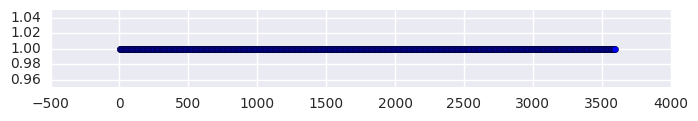

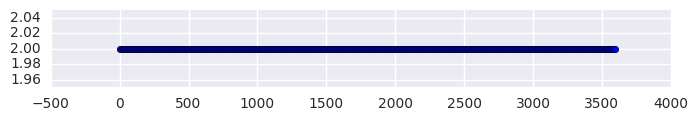

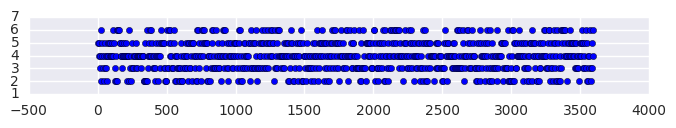

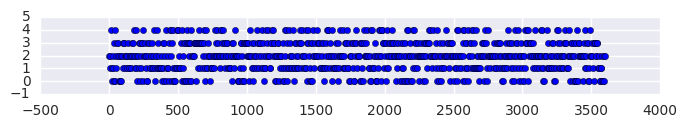

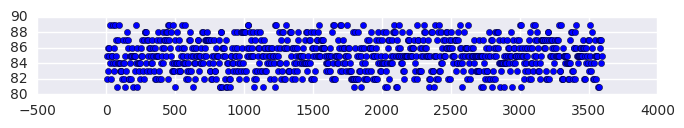

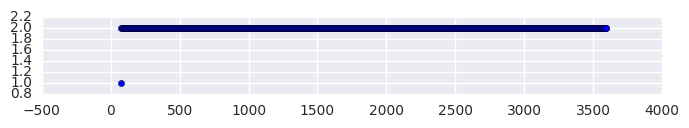

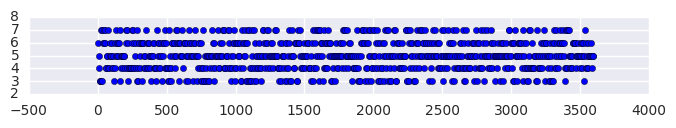

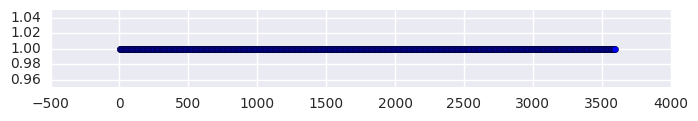

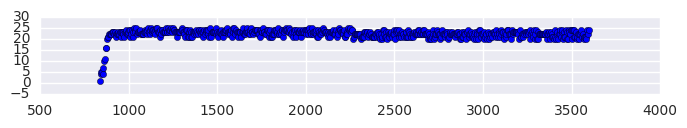

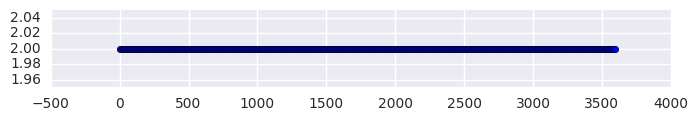

In [41]:
for post in list(d_scores.values())[20:30]:
    scores = []
    minutes = []
    for score in post:
        diff = (score['created_at'] - parser.parse("2016-12-06 00:00:00"))
        scores.append(score['score'])
        minute = diff.seconds/60 + diff.days*1440
        minutes.append(minute)
    plt.figure(figsize=(8,1))
    plt.scatter(minutes, scores)
    plt.show()

In [42]:
query_text = """
select * from experiment_things JOIN
  experiment_thing_snapshots ON
  experiment_thing_snapshots.experiment_thing_id = experiment_things.id
  WHERE experiment_thing_snapshots.created_at >= "2016-12-07 12:00:00"
  AND experiment_things.created_at <= DATE_SUB( NOW() , INTERVAL 1 DAY )
  ORDER BY experiment_thing_snapshots.created_at ASC;
"""

# since we are going in ascending order, we only need to store one at a time
# newer scores will replace older ones
youngest_score = {}
for row in db_engine.execute(text(query_text)):
    metadata = json.loads(row['metadata_json'])
    snapshot = {}
    for key in row.keys():
        snapshot[key] = row[key]
    for key in metadata.keys():
        snapshot[key] = metadata[key]
    del snapshot['metadata_json']
    minutes_before_algorithm_change
    if(snapshot['experiment_thing_id'] in youngest_score.keys() and 
       snapshot['experiment_thing_id'] in all_posts.keys()):
        if((snapshot['created_at'] - 
            all_posts[snapshot['experiment_thing_id']]['created_at']) < 
           time_before_algorithm_change):
            interval = (snapshot['created_at'] - all_posts[snapshot['experiment_thing_id']]['created_at'])
            snapshot['later.score.interval.minutes'] = int(interval.days*1440 + interval.seconds/60)
            youngest_score[snapshot['experiment_thing_id']] = snapshot
    else:
        try:
            interval = (snapshot['created_at'] - all_posts[snapshot['experiment_thing_id']]['created_at'])
            snapshot['later.score.interval.minutes'] = int(interval.days*1440 + interval.seconds/60)
        except:
            pass
        youngest_score[snapshot['experiment_thing_id']] = snapshot

In [46]:
for post in snapshotted_posts:
    post['later.score'] = youngest_score[post['id']]['score']
    post['later.score.interval.minutes'] = youngest_score[post['id']]['later.score.interval.minutes']

### Generate Post Level Dataset For Analysis
Includes only posts that had at least 24 hours since posting

In [47]:
post_df = pd.DataFrame(snapshotted_posts)
posts_filename = "r_worldnews_posts_01.19.2017.a.csv"
post_df.to_csv(os.path.join("outputs",posts_filename))

In [48]:
#len(snapshotted_posts)
#sorted(snapshotted_posts, key=lambda x: x['created'])[-1]

### Generate Max Rank For Analysis

In [49]:
# import csv
# max_rows = {}
# with open("outputs/worldnews_frontpages_max_2017-01-16.csv", "r") as f:
#     for row in csv.DictReader(f):
#         if(row['sub_id']==' ' or row['sub_id'].strip()!=subreddit_id):
#             continue
#         max_rows[row['post_id']] = row

#### Check to see if all experiment posts are in the max rows lists

In [50]:
# included = 0
# excluded = []
# for post in snapshotted_posts:
#     if post['id'] in max_rows.keys() and max_rows[post['id']]['SubredditPage HOT'] !=' ':
#         included += 1
#         post['max.hot'] = max_rows[post['id']]['SubredditPage HOT'].strip()
#     else:
#         post['max.hot'] = None
#         excluded.append(post)
# print("Included in top 200: {0}".format(included))
# print("Excluded from top 200: {0}".format(len(excluded)))
# print("Among Excluded, how many were removed:")
# print("     " + str(Counter([x['visible'] for x in excluded])))

In [51]:
# post_df = pd.DataFrame(snapshotted_posts)
# posts_filename = "r_worldnews_posts_01.17.2017.csv"
# post_df.to_csv(os.path.join("outputs",posts_filename))

In [52]:
#Counter([x['max.hot'] for x in snapshotted_posts])

### Load Information about Score Over First 24 Hours
Use only posts from the experiment that have been around for 24 hours or more

In [53]:
query_text = """
select * from experiment_things JOIN
  experiment_thing_snapshots ON
  experiment_thing_snapshots.experiment_thing_id = experiment_things.id
  WHERE experiment_things.experiment_id=8 AND experiment_things.object_type=1 AND
  DATE_ADD(experiment_things.created_at, INTERVAL 1 DAY) <= NOW() AND 
  experiment_thing_snapshots.created_at <= DATE_ADD(experiment_things.created_at, INTERVAL 1 DAY )
  ORDER BY experiment_thing_snapshots.created_at ASC;
"""

tf_score_snapshots = defaultdict(list)
for row in db_engine.execute(text(query_text)):
    metadata = json.loads(row['metadata_json'])
    snapshot = {}
    for key in row.keys():
        snapshot[key] = row[key]
    for key in metadata.keys():
        snapshot[key] = metadata[key]
    del snapshot['metadata_json']
    tf_score_snapshots[snapshot['experiment_thing_id']].append(snapshot)

In [54]:
#len(tf_score_snapshots)
#list(tf_score_snapshots.values())[0]
post_scores = []
errors  =0 
for scores in list(tf_score_snapshots.values()):
    try:
        post = all_posts[scores[0]["experiment_thing_id"]]
        for score in scores:
            p = copy.copy(post)
            for key in score.keys():
                p['score.'+key.replace("_", ".")] = score[key]
            post_scores.append(p)
    except:
        errors +=1
        pass
print("{0} errors".format(errors))

362 errors


In [55]:
scores_df = pd.DataFrame(post_scores)
scores_filename = "r_worldnews_scores_01.20.2017.a.csv"
scores_df.to_csv("outputs/" + scores_filename)

## Calculate Ranking Dataset

### Step One: Creation Date For  All Posts in DB

In [56]:
post_creation = {}
for row in db_engine.execute(text("select * from posts WHERE subreddit_id = '2qh13';")):
    post_creation[row['id']] = row['created']

### Step Two: Collect a dataset of all rankings

In [57]:
def timediff_minutes(timediff):
    return timediff.seconds/60 + timediff.days*1440
post_rankings = defaultdict(list)
for page in db_engine.execute(text("select * from subreddit_pages WHERE subreddit_id='2qh13' AND page_type={0} AND created_at > '{1}' AND created_at < '{2}';".format(
    4, #PageType.HOT
    earliest_date,
    ranking_latest_date
))):
    posts = json.loads(page['page_data'])
    median_score = np.median([x['score'] for x in posts])
    post_ages = []
    
    
    for post in posts:
        try:
            age = page.created_at - post_creation[post['id']]
        except:
            
            submission = r.get_submission(submission_id = post['id'])
            if(submission):
                age = page.created_at - datetime.datetime.utcfromtimestamp(submission.created_utc)
            else:
                age = None
        post_ages.append(timediff_minutes(age))
    
    ### FOR NOW OMIT MEDIAN AGE IF THERE'S MISSING INFO
    try:
        median_age = np.median(post_ages)
    except:
        median_age = None
    position = 0

    ### limit to the first 100 items
    ### since we don't have 300 
    ### until much later
    for post in posts[0:100]:
        try:
            age = timediff_minutes(page.created_at - post_creation[post['id']])
        except:
            age = None
        snapshot = {"created_at":page.created_at,
                    "snapshot.length":len(posts),
                    "position":position,
                    "median.score":median_score,
                    "median.age":median_age,
                    "post.score":post['score'],
                    "post.age": age,
                    "snapshot.comments":post['num_comments'],
                    "post.id":post['id']}
        post_rankings[post['id']].append(snapshot)
        position += 1

In [58]:
removed_post_snapshots = 0
for post in post_rankings.values():
    for snapshot in post:
        ## remove any entries that are older than 24 hours
        if(snapshot['post.age']>60*24):
            post.remove(snapshot)
            removed_post_snapshots += 1
print("Removed {0} post ranking snapshots older than 24 hours".format(removed_post_snapshots))

Removed 152769 post ranking snapshots older than 24 hours


In [59]:
ranking_snapshot_count = sum([len(x) for x in list(post_rankings.values())])
unique_post_count = len([x for x in list(post_rankings.values()) if len(x)>0])
print("Current status: {0} snapshots of {1} posts".format(ranking_snapshot_count, unique_post_count))

Current status: 1810331 snapshots of 16914 posts


### Create A Max Rank Field

In [60]:
for post in snapshotted_posts:
    if post['id'] in post_rankings.keys():
        rankings = post_rankings[post['id']]
        topmost_rank = rankings[0]['position']
        for ranking in rankings:
            if(topmost_rank > ranking['position']):
                topmost_rank = ranking['position']
        max_rank = abs(101 - topmost_rank)
    else:
        max_rank = 0
    post['max.rank'] = max_rank

In [61]:
#snapshotted_posts[0]
print("cat")

cat


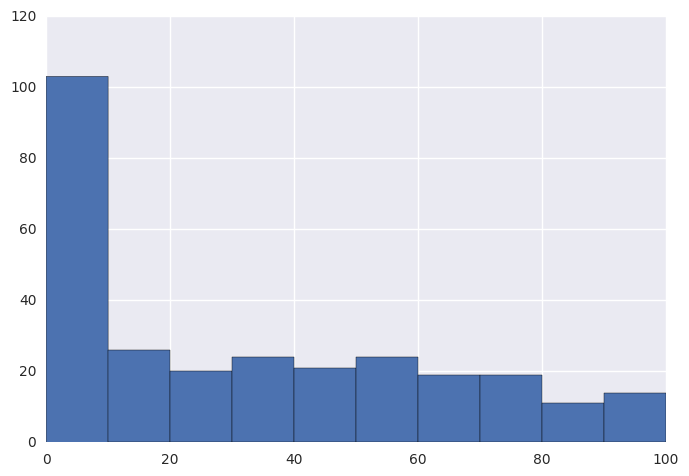

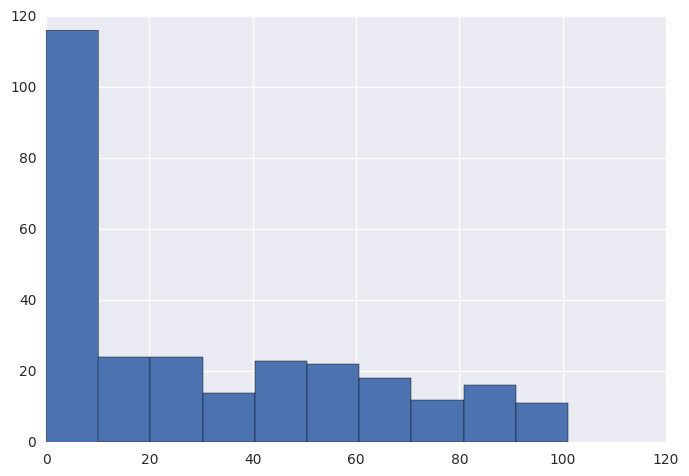

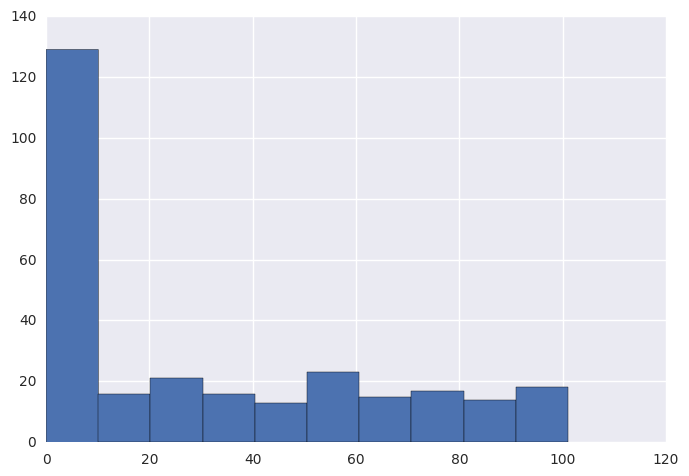

In [63]:
plt.hist([x['max.rank'] for x in snapshotted_posts if x['post.treatment']=='0'])
plt.show()
plt.hist([x['max.rank'] for x in snapshotted_posts if x['post.treatment']=='1'])
plt.show()
plt.hist([x['max.rank'] for x in snapshotted_posts if x['post.treatment']=='2'])
plt.show()
# #np.vstack([x, y]).T

In [67]:
### NOW WRITE RANKED POSTS TO FILE
ranked_post_df = pd.DataFrame(snapshotted_posts)
ranked_posts_filename = "r_worldnews_posts_ranked_01.19.2017.a.csv"
ranked_post_df.to_csv(os.path.join("outputs",ranked_posts_filename))

### Create a Ranking Dataset of Experiment Posts

In [64]:
experiment_post_rankings = []
for post in snapshotted_posts:
    ranking_info = copy.copy(post_rankings[post['id']])
    for snapshot in ranking_info:
        for key in post.keys():
            if(key not in ["metadata_json", "report_reasons", "mod_reports", "secure_media_embed"]):
                snapshot['post.'+key] = post[key]
        experiment_post_rankings.append(snapshot)

In [65]:
#experiment_post_rankings[0]

In [66]:
exp_rankings_df = pd.DataFrame(experiment_post_rankings)
exp_rankings_filename = "r_worldnews_exp_rankings_01.19.2017.a.csv"
exp_rankings_df.to_csv("outputs/" + exp_rankings_filename)

### Create a Ranking Dataset of All Posts

In [ ]:
all_rankings = []
for rankings in post_rankings.values():
    all_rankings.extend(rankings)
rankings_df = pd.DataFrame(all_rankings)
rankings_filename = "r_worldnews_rankings_01.19.2017.csv"
rankings_df.to_csv("outputs/" + rankings_filename)

In [ ]:
all_rankings[1]

## Understanding the Context
* Analyze the comments
* Analyze the posts themselves (confirmed that the rejection or submission rates haven't changed)

#### Analyze Domain Links

In [ ]:
for i in [0,1,2]: 
    tabloid = 0
    msm = 0
    other = 0
    for domain in domain_mentions_unique_comments[i]:
        matched = False
        for td in tabloid_domains:
            if(domain.find(td)!=-1):
                tabloid += 1
                matched = True
        for md in msm_domains:
            if(domain.find(md)!=-1):
                msm += 1
                matched = True
        if(matched!=True):
            other += 1
                
    print("Experiment Arm {0}".format(i))
    print("{0} Tabloid links".format(tabloid))
    print("{0} MSM links".format(msm))
    print("{0} other links".format(other))
    #sorted(domain_mentions_unique_comments[0].items(),key=lambda x: x[1], reverse=True)[0:25]
    print()

In [ ]:
def threelist():
    return {0:0,1:0,2:0, "domain":""}
domain_arms = defaultdict(threelist)
for i in [0,1,2]:
    for item in domain_mentions_unique_comments[i].items():
        domain = item[0]
        omit = False
        for m in omitted_matches:
            if(domain.find(m)>-1):
                omit = True
        if(omit!=True):
            domain_arms[item[0]][i] = item[1]
            domain_arms[item[0]]["domain"] = domain
domain_arms_df = pd.DataFrame(list(domain_arms.values()))
domain_arms_filename = "r_worldnews_domain_arms_01.19.2017.csv"
domain_arms_df.to_csv(os.path.join("outputs",domain_arms_filename))

In [ ]:
def threelist():
    return {0:0,1:0,2:0, "domain":""}
excluded_domain_arms = defaultdict(threelist)
for i in [0,1,2]:
    for item in excluded_domain_mentions_unique_comments[i].items():
        domain = item[0]
        excluded_domain_arms[item[0]][i] = item[1]
        excluded_domain_arms[item[0]]["domain"] = domain
excluded_domain_arms_df = pd.DataFrame(list(excluded_domain_arms.values()))
excluded_domain_arms_filename = "r_worldnews_domains_excluded_arms_01.19.2017.csv"
excluded_domain_arms_df.to_csv(os.path.join("outputs",excluded_domain_arms_filename))

In [ ]:
#excluded_domain_arms

### Remaining Tasks:

* Confirm which blocks to include and exclude (done)
* Include and exclude those blocks (done)
* Recalculate existing analyses (done)
* Do the score predictions (in progress)
* Make a decision about score and the algorithm change
* Include info on excluded domains
* Include a random sample of headlines

In [ ]:
#Counter([x['post.block.id'] for x in snapshotted_posts if x['later.score.interval.minutes']>=13000])
Counter([x['post.block.id'] for x in snapshotted_posts])

In [ ]:
import random
random.seed(23458233)

removed = random.sample([x for x in snapshotted_posts if x['visible'] is False], 40)
kept = random.sample([x for x in snapshotted_posts if x['visible'] is True], 40)

In [ ]:
removed_submissions = []
for submission in r.get_submissions([x['name'] for x in removed]):
    removed_submissions.append(submission)

In [ ]:
for i in removed_submissions[0:50]:
    print("* [*{0}*] {1}".format(i.json_dict['link_flair_text'], i.json_dict['title']))

In [ ]:
for i in kept[0:10]:
    print("* {0}".format(i))

### Who Did the Fact-Checking?

In [ ]:
author_links = 0
commenters = []
for comment in recent_comments_included:
    if(comment['link_count']>0):
        commenters.append(comment['author'])
        if(comment['author']==comment['post.author']):
            author_links += 1

In [ ]:
print("{0} comments with links".format(len(commenters)))
print("{0} unique commenters".format(len(set(commenters))))
print("{0} of these comments were made by the post author".format(author_links))
#plt.hist([x[1] for x in Counter(commenters).items()])

In [ ]:
comment_list = sorted(Counter(commenters).items(), key=lambda x: x[1], reverse=True)

In [ ]:
len([x for x in comment_list if x[1]>1])

In [ ]:
sorted(domain_mentions_unique_comments[1].items(), key=lambda x: x[1], reverse=True)